# Feature Extraction: From EEG Signals to Meaningful Features

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy import signal
from scipy.stats import skew, kurtosis

In [2]:
# Load the preprocessed data
print("🔍 Loading Preprocessed Data...")
data_dir = '../data/preprocessed'
raw_clean = mne.io.read_raw_fif(f'{data_dir}/sample_clean_eeg_raw.fif', preload=True)

# Load preprocessing info
with open(f'{data_dir}/preprocessing_info.json', 'r') as f:
    preprocess_info = json.load(f)

print("✅ Data loaded successfully!")
print(f"Channels: {len(raw_clean.ch_names)}")
print(f"Sampling rate: {raw_clean.info['sfreq']} Hz")
print(f"Duration: {raw_clean.times[-1]:.1f} seconds")
print(f"\n📋 Preprocessing applied:")
print(f"  - Filter: {preprocess_info['filter_low']}-{preprocess_info['filter_high']} Hz")
print(f"  - Artifacts removed: {len(preprocess_info['artifacts_removed'])} components")

🔍 Loading Preprocessed Data...
Opening raw data file ../data/preprocessed/sample_clean_eeg_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
✅ Data loaded successfully!
Channels: 59
Sampling rate: 150.15374755859375 Hz
Duration: 277.7 seconds

📋 Preprocessing applied:
  - Filter: 0.1-30.0 Hz
  - Artifacts removed: 1 components


### Step 1: Create epochs for feature extraction

In [3]:
print("Step 1: Creating Epochs")

# Load events from the original raw file (since we need the stimulus channel)
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
raw_original = mne.io.read_raw_fif(sample_data_raw_file)
events = mne.find_events(raw_original, stim_channel='STI 014')

# Create epochs (2-second windows around each event)
event_dict = {'condition_1': 1, 'condition_2': 2}
epochs = mne.Epochs(raw_clean, events, event_dict,
                   tmin=-0.2, tmax=1.8,  # 2 seconds total
                   baseline=(None, 0),
                   preload=True)

print(f"Created {len(epochs)} epochs")
print(f"Conditions: {list(epochs.event_id.keys())}")

Step 1: Creating Epochs
Opening raw data file C:\Users\arash\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Finding events on: STI 014
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
145 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 145 events and 301 original time points ...
0 bad epochs dropped
Created 145 epochs
Conditions: ['condition_1', 'condition_2']


### Step 2: Extract Statistical Features

These describe the shape and behavior of the raw EEG signal over time.

In [4]:
print("\n📊 Step 2: Extracting Statistical Features")

def extract_statistical_features(epoch_data):
    """
    Extract statistical features from a single epoch
    epoch_data: shape (n_channels, n_timepoints)
    """
    features = {}
    
    for ch_idx, ch_name in enumerate(raw_clean.ch_names):
        signal = epoch_data[ch_idx, :]
        
        # Basic statistics
        features[f'{ch_name}_mean'] = np.mean(signal)
        features[f'{ch_name}_std'] = np.std(signal)
        features[f'{ch_name}_var'] = np.var(signal)
        features[f'{ch_name}_min'] = np.min(signal)
        features[f'{ch_name}_max'] = np.max(signal)
        features[f'{ch_name}_range'] = np.max(signal) - np.min(signal)
        
        # Higher-order statistics
        features[f'{ch_name}_skewness'] = skew(signal)
        features[f'{ch_name}_kurtosis'] = kurtosis(signal)
        
        # Signal complexity
        features[f'{ch_name}_zero_crossings'] = np.sum(np.diff(np.sign(signal)) != 0)
        
    return features

# Extract features from first epoch as example
sample_epoch = epochs.get_data()[0]  # Shape: (n_channels, n_timepoints)
sample_features = extract_statistical_features(sample_epoch)

print(f"✅ Extracted {len(sample_features)} statistical features")
print("\nExample features:")
for i, (key, value) in enumerate(list(sample_features.items())[:5]):
    print(f"  {key}: {value:.6f}")


📊 Step 2: Extracting Statistical Features
✅ Extracted 531 statistical features

Example features:
  EEG 001_mean: 0.000003
  EEG 001_std: 0.000005
  EEG 001_var: 0.000000
  EEG 001_min: -0.000011
  EEG 001_max: 0.000016


### Step 3: Spectral Features (Frequency Domain)

These describe what frequencies (brain rhythms) are present in the signal.

In [5]:
print("\n🌊 Step 3: Extracting Spectral Features (Frequency Bands)")

# Define EEG frequency bands
freq_bands = {
    'delta': (0.5, 4),    # Deep sleep
    'theta': (4, 8),      # Drowsiness, meditation
    'alpha': (8, 13),     # Relaxed, eyes closed
    'beta': (13, 30),     # Active thinking, focus
    'gamma': (30, 45)     # High-level cognition (if you had higher sampling)
}

def extract_spectral_features(epoch_data, sfreq):
    """
    Extract power spectral density features
    """
    features = {}
    
    for ch_idx, ch_name in enumerate(raw_clean.ch_names):
        signal_data = epoch_data[ch_idx, :]
        
        # Compute power spectral density
        freqs, psd = signal.welch(signal_data, fs=sfreq, nperseg=256)
        
        # Extract power in each frequency band
        for band_name, (low_freq, high_freq) in freq_bands.items():
            # Find frequencies in this band
            band_mask = (freqs >= low_freq) & (freqs <= high_freq)
            band_power = np.mean(psd[band_mask])
            
            features[f'{ch_name}_{band_name}_power'] = band_power
        
        # Total power
        features[f'{ch_name}_total_power'] = np.sum(psd)
        
        # Relative band powers (normalized)
        total_power = np.sum(psd)
        for band_name in freq_bands.keys():
            rel_power = features[f'{ch_name}_{band_name}_power'] / total_power
            features[f'{ch_name}_{band_name}_rel_power'] = rel_power
    
    return features

# Extract spectral features from sample epoch
sfreq = raw_clean.info['sfreq']
spectral_features = extract_spectral_features(sample_epoch, sfreq)

print(f"✅ Extracted {len(spectral_features)} spectral features")
print("\nExample spectral features:")
for i, (key, value) in enumerate(list(spectral_features.items())[:5]):
    print(f"  {key}: {value:.2e}")


🌊 Step 3: Extracting Spectral Features (Frequency Bands)
✅ Extracted 649 spectral features

Example spectral features:
  EEG 001_delta_power: 9.16e-13
  EEG 001_theta_power: 1.25e-12
  EEG 001_alpha_power: 7.17e-13
  EEG 001_beta_power: 4.09e-13
  EEG 001_gamma_power: 1.83e-13


### Step 4: Combine all features for all epochs

Why do we need both features?

Both are needed because:
- Two signals can have the same mean but completely different rhythms
- Two signals can have the same frequency content but different amplitudes

In [6]:
print("\n⚙️ Step 4: Extracting Features for All Epochs...")

all_features = []
all_labels = []

epoch_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)
epoch_labels = epochs.events[:, 2]  # Condition labels

for i, (epoch, label) in enumerate(zip(epoch_data, epoch_labels)):
    if i % 20 == 0:
        print(f"  Processing epoch {i+1}/{len(epoch_data)}...")
    
    # Extract all features
    features = {}
    features.update(extract_statistical_features(epoch))
    features.update(extract_spectral_features(epoch, sfreq))
    
    all_features.append(features)
    all_labels.append(label)

# Convert to DataFrame
features_df = pd.DataFrame(all_features)
features_df['label'] = all_labels
features_df['condition'] = features_df['label'].map({1: 'condition_1', 2: 'condition_2'})

print(f"\n✅ Feature extraction complete!")
print(f"Total epochs: {len(features_df)}")
print(f"Total features per epoch: {len(features_df.columns) - 2}")  # Exclude label columns
print(f"\nDataFrame shape: {features_df.shape}")
print(f"\nFirst few rows:")
print(features_df.head())


⚙️ Step 4: Extracting Features for All Epochs...
  Processing epoch 1/145...
  Processing epoch 21/145...
  Processing epoch 41/145...
  Processing epoch 61/145...
  Processing epoch 81/145...
  Processing epoch 101/145...
  Processing epoch 121/145...
  Processing epoch 141/145...

✅ Feature extraction complete!
Total epochs: 145
Total features per epoch: 1180

DataFrame shape: (145, 1182)

First few rows:
   EEG 001_mean  EEG 001_std   EEG 001_var  EEG 001_min  EEG 001_max  \
0  3.264015e-06     0.000005  2.465126e-11    -0.000011     0.000016   
1 -1.649031e-07     0.000006  3.160354e-11    -0.000014     0.000013   
2 -7.428450e-06     0.000006  3.777216e-11    -0.000023     0.000011   
3  1.845961e-07     0.000005  2.643376e-11    -0.000015     0.000012   
4  2.838977e-06     0.000004  1.819309e-11    -0.000009     0.000018   

   EEG 001_range  EEG 001_skewness  EEG 001_kurtosis  EEG 001_zero_crossings  \
0       0.000026         -0.131729         -0.356070                      4

### Visualize the features


📈 Step 5: Visualizing Feature Distributions


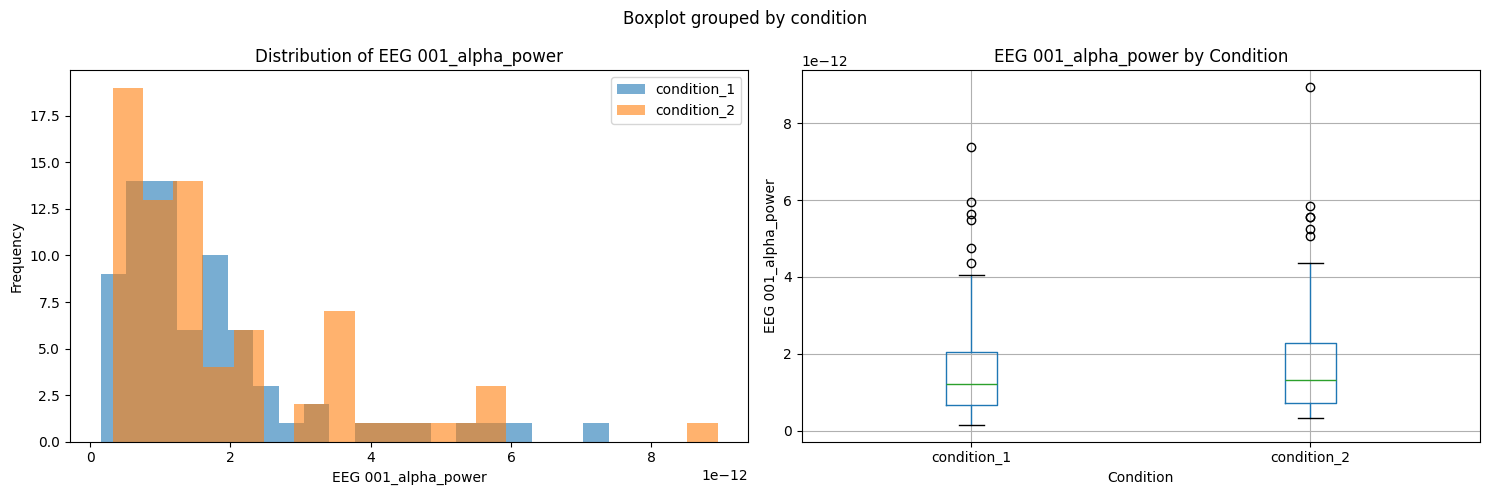


📊 Statistical comparison:
condition_1: mean=1.66e-12, std=1.45e-12
condition_2: mean=1.89e-12, std=1.65e-12


In [7]:
print("\n📈 Step 5: Visualizing Feature Distributions")

# Plot distribution of alpha power for one channel
channel = 'EEG 001'
feature_name = f'{channel}_alpha_power'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
for condition in ['condition_1', 'condition_2']:
    data = features_df[features_df['condition'] == condition][feature_name]
    axes[0].hist(data, alpha=0.6, bins=20, label=condition)

axes[0].set_xlabel(f'{feature_name}')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of {feature_name}')
axes[0].legend()

# Box plot
features_df.boxplot(column=feature_name, by='condition', ax=axes[1])
axes[1].set_title(f'{feature_name} by Condition')
axes[1].set_xlabel('Condition')
axes[1].set_ylabel(f'{feature_name}')

plt.tight_layout()
plt.show()

print(f"\n📊 Statistical comparison:")
for condition in ['condition_1', 'condition_2']:
    data = features_df[features_df['condition'] == condition][feature_name]
    print(f"{condition}: mean={data.mean():.2e}, std={data.std():.2e}")

Left plot (histogram): Shows how often different alpha power values occur in our data
- Most epochs have LOW alpha power values
- Both conditions have similar distributions (hence the overlap)
- There are a few outliers on the right side

Right plot (Boxplot): shows the spread of alpha power values for each condition

For this one feature it might be hard to distinguish the conditions, however, we have 1180 features per epoch, so it should be fine.

### Save these features for Bayesian Modeling

In [8]:
print("\n💾 Step 6: Saving Features for Bayesian Modeling")

# Save to CSV
features_file = '../data/preprocessed/eeg_features.csv'
features_df.to_csv(features_file, index=False)
print(f"✅ Saved features to: {features_file}")

# Save feature metadata
feature_metadata = {
    'n_epochs': len(features_df),
    'n_features': len(features_df.columns) - 2,
    'feature_names': list(features_df.columns[:-2]),
    'conditions': list(features_df['condition'].unique()),
    'frequency_bands': freq_bands,
    'sampling_rate': float(sfreq)
}

metadata_file = '../data/preprocessed/feature_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"✅ Saved metadata to: {metadata_file}")

print(f"\n🎉 FEATURE EXTRACTION COMPLETE!")
print(f"📊 Ready for BAYESIAN MODELING! 🎯")
print(f"\nNext steps:")
print(f"1. Load features: pd.read_csv('{features_file}')")
print(f"2. Build Bayesian models to compare conditions")
print(f"3. Make probabilistic inferences about brain states!")


💾 Step 6: Saving Features for Bayesian Modeling
✅ Saved features to: ../data/preprocessed/eeg_features.csv
✅ Saved metadata to: ../data/preprocessed/feature_metadata.json

🎉 FEATURE EXTRACTION COMPLETE!
📊 Ready for BAYESIAN MODELING! 🎯

Next steps:
1. Load features: pd.read_csv('../data/preprocessed/eeg_features.csv')
2. Build Bayesian models to compare conditions
3. Make probabilistic inferences about brain states!
